# Analysis of HCP behavioral dataset

Rekha Varrier, main analyses Nov 2020 - Jan 2021.
- Some of the results were presented in an OHBM 2021 poster

Below are the steps to analyse the behavioral data of the HCP social task

In [296]:
#Importing data and packages, creating convenient variables
#%reset
import os
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%matplotlib inline


folder = os.getcwd()
print('current dir: ',folder)
path = Path(folder)
parent_folder = path.parent
file_loc = os.path.join(parent_folder,'data')
print('data folder:',file_loc)
dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding.csv')


current dir:  /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/code
data folder: /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data


In [297]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [305]:
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

dat = pd.read_csv(dataFile)# , index_col = "subj_idx")
dat["run"] = ["run2" if x.split('.')[0] in vid_names["run1"] else "run1" for x in dat["movie"]]
dat["run"] = [0 if x.split('.')[0] in vid_names["run1"] else 1 for x in dat["movie"]]

print("n=",len(np.unique(dat["subj_idx"])))
dat.head(10)

n= 1051


,subj_idx,stim,movie,rt,response,run
0,168745,Mental,Scaring.AVI,1.252,1,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1
2,168745,Random,STAR-A.AVI,1.643,0,1
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1
4,168745,Random,TENNIS-A.AVI,1.232,0,1
5,668361,Mental,COAXING-B.AVI,1.796,9,0
6,668361,Random,BILLIARD-A.AVI,1.254,0,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0
8,668361,Mental,Fishing.AVI,0.993,0,0
9,668361,Random,Random mechanical.AVI,0.816,0,0


In [306]:
#add accuracy as an additional column, remove impossible RTs

# add accuracy
acc = np.zeros((dat.shape[0],)) -1 # initialize accuracy with -1
correct = np.where(((dat['stim'] == 'Mental') & (dat['response'] == 1)) | ((dat['stim'] == 'Random') & (dat['response'] == 0)))[0]
wrong = np.where(((dat['stim'] == 'Mental') & (dat['response'] == 0)) | ((dat['stim'] == 'Random') & (dat['response'] == 1)))[0]
unsure = np.where(dat['response'] == 9)[0]
acc[correct] = 1
acc[wrong]= 0
acc[unsure] = 9
dat['accuracy'] = acc

# remove imppossible RTs
rtmin = 0.15 # threshold for impossibly short RTs
print('nrows before=',dat.shape[0])
dat= dat.loc[dat['rt']>=rtmin,:]
print('nrows after=',dat.shape[0])
#dat.head()


nrows before= 10149
nrows after= 9948


In [307]:
#excluding bad subs: defined as those who have less than 'thresh' trials
# defined as 8/10 responses "sure", i.e., yes/no
# did this to make sure we have a good number of trials/subject - since our main analyses were only on the 
# sure trials

thresh = 10
trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)

Nr. of subjects left 821
Nr. of rows: (8210, 7)


In [308]:
#Sort into sure and unsure trials dfs
data_sure = dat[dat["response"]!=9]
data_unsure = dat[dat["response"] ==9]
len(np.unique(data_sure['subj_idx']))

821

### 1. Descriptives
### (a) Number of yes/no responses per sub (for paper)

- to evaluate if there are more Yes responses than No responses on average - suggesting a Yes bias

In [309]:
counts_per_subj = data_sure.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj = counts_per_subj.unstack(level = -1)
counts_per_subj['diff'] = counts_per_subj[1]-counts_per_subj[0]
counts_per_subj['sum'] = counts_per_subj[1]+counts_per_subj[0]
counts_per_subj


response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [310]:
# exclude subs with 0 responses in social/nonsocial and subjs with fewer than 8 yes/no responses
rows = ~np.isnan(counts_per_subj['diff'])
counts_per_subj = counts_per_subj.loc[rows,:]
counts_per_subj.shape

(819, 4)

In [311]:
# compute response perceptages and theur diiference
counts_per_subj.loc[:,'No_pc']  = 100*counts_per_subj.loc[:,0]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Yes_pc'] = 100*counts_per_subj.loc[:,1]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Soc-NonSoc_pc'] = counts_per_subj.loc[:,'Yes_pc'] - counts_per_subj.loc[:,'No_pc']
counts_per_subj

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


response,0,1,diff,sum,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


Ttest_1sampResult(statistic=9.9485142257805, pvalue=4.333749690340175e-22)

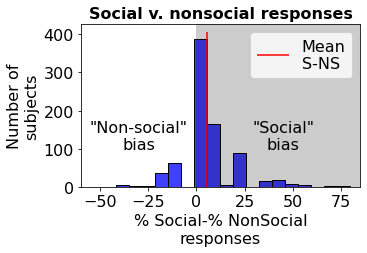

In [312]:
plt.figure(1,figsize=(5,3))
sns.histplot(data=counts_per_subj,bins=20,x='Soc-NonSoc_pc',color='b')
plt.xlabel('% Social-% NonSocial\nresponses')
plt.ylabel('Number of\nsubjects')
ymin,ymax = plt.ylim()
plt.vlines(counts_per_subj.mean()['Soc-NonSoc_pc'],ymin,ymax,color = 'r',label = 'Mean\nS-NS')
plt.xticks([-75,-50,-25,0,25,50,75])
plt.legend(loc='upper right')
plt.xlim(-60,85)
xmin,xmax = plt.ylim()
plt.axvspan(0,xmax, facecolor= '0', alpha=0.2) # background color for the first 5 bars(mental?)
plt.axvspan(xmin,0, facecolor='0.1', alpha=0.2) # background color for the first 5 bars(mental?)

plt.text(-30,100,'"Non-social"\nbias', ha='center', color = 'black')
plt.text(45,100,'"Social"\nbias', ha='center', color = 'black')
plt.title("Social v. nonsocial responses",fontweight='bold')

stats.ttest_1samp(counts_per_subj['Soc-NonSoc_pc'], 0)


In [313]:
for q in [.25,.5,.75]:
    print(np.quantile(counts_per_subj['Yes_pc'],q))
for q in [.25,.5,.75]:
    print(np.quantile(counts_per_subj['No_pc'],q))

50.0
50.0
55.55555555555556
44.44444444444444
50.0
50.0


In [314]:
def box_plot(data, edge_color, fill_color,pos,v):
    bp = ax.boxplot(data, positions = [pos], patch_artist=True,widths=.5,vert=v)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for element in ['medians']:
        plt.setp(bp[element], color='k',linewidth=2,ls='dashed')

    for patch in bp['boxes']:
        patch.set(facecolor='w')       
        
    return bp
    
'''example_data1 = [[1,2,0.8], [0.5,2,2], [3,2,1]]
example_data2 = [[5,3, 4], [6,4,3,8], [6,4,9]]

bp1 = box_plot(example_data1, 'red', 'tan')
bp2 = box_plot(example_data2, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Data 1', 'Data 2'])
ax.set_ylim(0, 10)
plt.show()'''

'example_data1 = [[1,2,0.8], [0.5,2,2], [3,2,1]]\nexample_data2 = [[5,3, 4], [6,4,3,8], [6,4,9]]\n\nbp1 = box_plot(example_data1, \'red\', \'tan\')\nbp2 = box_plot(example_data2, \'blue\', \'cyan\')\nax.legend([bp1["boxes"][0], bp2["boxes"][0]], [\'Data 1\', \'Data 2\'])\nax.set_ylim(0, 10)\nplt.show()'

mean diff: 5.57232009612962


Ttest_relResult(statistic=-9.9485142257805, pvalue=4.333749690340175e-22)

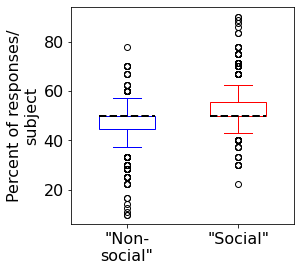

In [315]:
fig, ax = plt.subplots(figsize=(4,4))
#plt.figure(1,figsize=(3,4))
#plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
#ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
bp1 = box_plot(counts_per_subj['Yes_pc'], 'red', 'tan',1,True)
bp2 = box_plot(counts_per_subj['No_pc'], 'blue', 'cyan',0,True)
#ax.set_ylim(0, 10)

#plt.axhspan(0,50, facecolor= '0.5', alpha=0.2) # background color for the first 5 bars(mental?)
#sns.barplot(data=counts_per_subj.loc[:,['No_pc','Yes_pc']].melt(),x='response',y='value',edgecolor = 'k',alpha=.5)
plt.xticks(range(2),['"Non-\nsocial"','"Social"'])
plt.ylabel('Percent of responses/\nsubject')
xmin,xmax = plt.xlim()
#plt.hlines(50,xmin,xmax,color= 'grey',ls='dashed')
#for i in range(counts_per_subj.shape[0]):
#    plt.plot(range(2),counts_per_subj.iloc[i,4:6],color='k',alpha=.2,label = 'subject')
#    if i ==0:
#       plt.legend()
#sns.lineplot(data=counts_per_subj.loc[:,['Yes_pc','No_pc']].T,color='g',alpha=.2)
plt.xlabel('')

print('mean diff:',np.nanmean(counts_per_subj['Yes_pc']-counts_per_subj['No_pc']))
stats.ttest_rel(counts_per_subj['No_pc'],counts_per_subj['Yes_pc'])

Ttest_1sampResult(statistic=9.971103525085562, pvalue=3.516092221705134e-22)

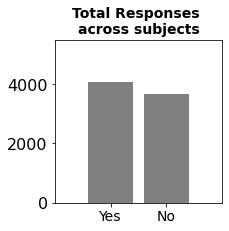

In [316]:
# compare yes vs. no responses, exploring df

ones = np.where(data_sure['response']==1)[0]
zeros = np.where(data_sure['response']==0)[0]

plt.figure(1, figsize=(3,3))
plt.bar(np.arange(1,3),[len(ones),len(zeros)],color = 'grey')
plt.xticks(np.arange(1,3),['Yes','No'], fontsize = 14)
plt.title('Total Responses \nacross subjects', fontsize =14, fontweight = 'bold')
plt.xlim(0,3)
plt.ylim(0,5500)

stats.ttest_1samp(data_sure.groupby(['subj_idx']).mean().response.values,.5,nan_policy='omit')

### (b) Accuracies social v. nonsocial (OHBM 2021 ABSTRACT FIG 1A)

stim      Mental  Random
subj_idx                
100206       1.0     0.2
100307       1.0     0.8
100408       1.0     1.0
100610       1.0     1.0
101309       1.0     1.0
...          ...     ...
991267       1.0     1.0
992673       1.0     1.0
992774       1.0     1.0
993675       1.0     1.0
996782       1.0     1.0

[821 rows x 2 columns] 

MEAN  stim
Mental    0.976269
Random    0.956090
dtype: float64 

SEM  stim
Mental    0.00262
Random    0.00420
dtype: float64 



Ttest_1sampResult(statistic=9.971103525085562, pvalue=3.516092221705134e-22)

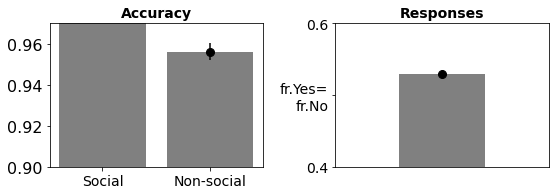

In [321]:
# compare social and random trial accuracies, exploring df 

accuracy_per_subj = data_sure.groupby(['subj_idx', 'stim']).mean().accuracy # Mean acc. per subject for Mental and Random
cols = accuracy_per_subj.unstack(level = -1)
print(cols,'\n') # subj_idx and stim are indices, so unstack makes stim columns (with the default level value)
print('MEAN ',cols.mean(),'\n') # mean acc across subjects
print('SEM ',cols.sem(),'\n') # sem acc across subjects
#print('COLUMNS', cols.columns) # Mental and random become columns with unstack

plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.bar(range(2),cols.mean(),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(range(2),cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.xticks((range(2)),('Social','Non-social'), fontsize = 14)
plt.title('Accuracy', fontsize =14, fontweight = 'bold')
plt.ylim(0.9,0.97)

stats.ttest_rel(cols['Mental'],cols['Random'],nan_policy='omit')


responses_per_subj = data_sure.groupby(['subj_idx']).mean().response # Mean acc. per subject for Mental and Random

plt.subplot(122)
plt.bar(1,np.nanmean(responses_per_subj.values),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(1,np.nanmean(responses_per_subj.values),stats.sem(responses_per_subj,nan_policy='omit'), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.yticks([0.4,0.5,0.6],['0.4','fr.Yes=\nfr.No','0.6'], fontsize = 14)
plt.title('Responses', fontsize =14, fontweight = 'bold')
plt.ylim(0.4,0.6)
plt.xlim(0,2)
plt.xticks([])

plt.tight_layout()
stats.ttest_1samp(responses_per_subj.values,.5,nan_policy='omit')

### 2. Movie-wise trends - Accuracy per movie  and #unsure responses/movie

acc_per_movie
stim    movie                
Mental  COAXING-B.AVI            0.989842
        Fishing.AVI              0.893827
        SEDUCING-B.AVI           0.989853
        SURPRISING-B.AVI         0.990022
        Scaring.AVI              0.971751
Random  BILLIARD-A.AVI           0.984848
        DRIFTING-A.AVI           0.963387
        Random mechanical.AVI    0.869102
        STAR-A.AVI               0.968858
        TENNIS-A.AVI             0.949005
Name: accuracy, dtype: float64


(0.8, 1.0)

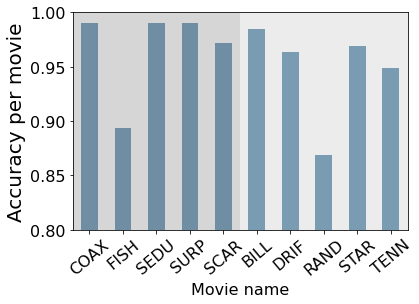

In [267]:
#Accuracy per movie (OHBM ABSTRACT FIG 2A)
acc_per_movie = data_sure.groupby(['stim','movie']).mean().accuracy
print('acc_per_movie')
print(acc_per_movie)

# (for the figure axlabels) creating groupwise movie name labels from the variable acc_per_movie
movieNames_grouped = []
for i in range(len(acc_per_movie.index)):
    movieNames_grouped.append(acc_per_movie.index[i][1])
#print('movieNames_grouped:',movieNames_grouped)
lbl = [str.upper(i[0:5]) for i in movieNames_grouped] # first four letters of each movie name

acc_per_movie.plot.bar(color = [0,0.3,0.5], alpha = 0.5)
plt.xlabel("Movie name")
plt.ylabel('Accuracy per movie', fontsize = 20)
lbl = [str.upper(i[0:4]) for i in movieNames_grouped] # first four letters of each movie name
plt.xticks(range(10),lbl, rotation = 40)
plt.axvspan(-0.5,4.5, facecolor='0.2', alpha=0.2) # background color for the first 5 bars(mental?)
plt.axvspan(4.5,10, facecolor='0.3', alpha=0.1) # bgcolor for the next 5 bars (random?)
plt.xlim(-0.5,9.5)
plt.ylim(0.8,1)

count_unsure_per_movie
stim    movie                
Mental  COAXING-B.AVI              9
        Fishing.AVI               90
        SEDUCING-B.AVI            25
        SURPRISING-B.AVI          11
        Scaring.AVI               32
Random  BILLIARD-A.AVI            47
        DRIFTING-A.AVI            57
        Random mechanical.AVI    187
        STAR-A.AVI                59
        TENNIS-A.AVI             124
dtype: int64


([<matplotlib.axis.XTick at 0x7fd1b4474a10>,
 [Text(0, 0, 'COAX'),
  Text(1, 0, 'FISH'),
  Text(2, 0, 'SEDU'),
  Text(3, 0, 'SURP'),
  Text(4, 0, 'SCAR'),
  Text(5, 0, 'BILL'),
  Text(6, 0, 'DRIF'),
  Text(7, 0, 'RAND'),
  Text(8, 0, 'STAR'),
  Text(9, 0, 'TENN')])

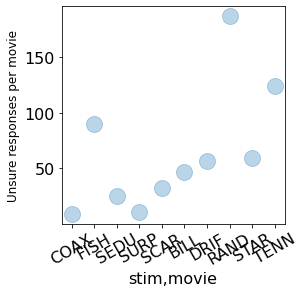

In [268]:
#Unsure trials per movie
count_unsure_per_movie = data_unsure.groupby(['stim','movie']).size()
print('count_unsure_per_movie')
print(count_unsure_per_movie)

# Plot no. of uncertain responses per movie
count_unsure_per_movie.plot(figsize = (4,4), x ='', y ='', linestyle = 'None', marker = 'o', markersize = 16, alpha = 0.3)
plt.ylabel('Unsure responses per movie', fontsize = 12)
plt.xticks(range(10),lbl, rotation = 30)



- So looks like there are movie-specific differences in uncertainty and accuracy - are these correlated?

In [269]:
stats.pearsonr(count_unsure_per_movie.values,acc_per_movie.values)

(-0.88128945446883, 0.0007510816838114219)

- Indeed, looks like there's a negative correlation - i.e., movies with higher uncertainty have lower accuracies - which makes sense

In [ ]:
stim_mean = data_sure.groupby(['movie']).mean().response # this shouldn't include unsure data
stim_mean.shape
n = len(vid_names["run1"])+len(vid_names["run2"])

socialness = np.zeros(len(data_sure['response']))
for m in range(n):
    rows = np.where(data_sure["movie"] == stim_mean.index[m])[0]
    socialness[rows] = stim_mean[m]
data_sure['socialness'] = socialness # add new column
data_sure.head(10)

resp_per_movie
stim    movie                
Mental  COAXING-B.AVI            0.989842
        Fishing.AVI              0.893827
        SEDUCING-B.AVI           0.989853
        SURPRISING-B.AVI         0.990022
        Scaring.AVI              0.971751
Random  BILLIARD-A.AVI           0.015152
        DRIFTING-A.AVI           0.036613
        Random mechanical.AVI    0.130898
        STAR-A.AVI               0.031142
        TENNIS-A.AVI             0.050995
Name: response, dtype: float64


Text(0, 0.5, 'Mean response per movie \n(socialness)')

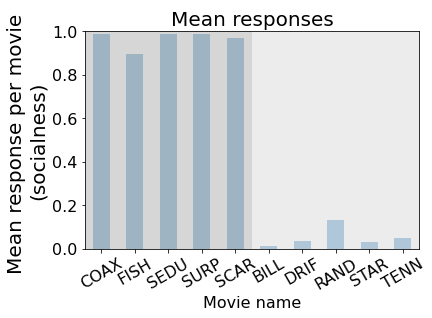

In [270]:
# another interesting variable - mean responses or mean socialness, but we don't need 
# this rn
resp_per_movie = data_sure.groupby(['stim','movie']).mean().response
print('resp_per_movie')
print(resp_per_movie)

resp_per_movie.plot.bar(x ='', y ='', linestyle = 'None', alpha = 0.3)
plt.xticks(range(10),lbl, rotation = 30)
plt.axvspan(-0.5,4.5, facecolor='0.2', alpha=0.2)
plt.axvspan(4.5,10, facecolor='0.3', alpha=0.1)
plt.xlim(-0.5,9.5)
plt.ylim(0,1)
plt.xlabel("Movie name")
plt.title('Mean responses',fontsize = 20)
plt.ylabel('Mean response per movie \n(socialness)', fontsize = 20)

(10, 3)


Text(0, 0.5, 'Umambiguity')

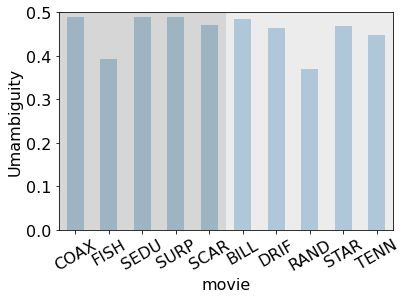

In [271]:
# another interesting variable--> unambiguity or distance from the centre (0.5), but we don't need this rn
# in the initial days/presentations, this variable was called 'certainty'

unambiguity = resp_per_movie.reset_index()
print(unambiguity.values.shape)
unambiguity['response'] = np.abs(0.5-unambiguity['response'])

unambiguity.plot.bar(x ='movie', y ='response', linestyle = 'None', alpha = 0.3, legend = None)
plt.xticks(range(10),lbl, rotation = 30)
plt.axvspan(-0.5,4.5, facecolor='0.2', alpha=0.2)
plt.axvspan(4.5,10, facecolor='0.3', alpha=0.1)
plt.xlim(-0.5,9.5)
plt.ylim(0,0.5)
plt.ylabel('Umambiguity')

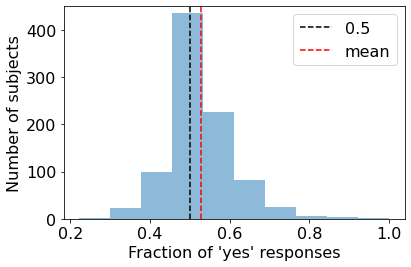

In [272]:
#mean responses per subject - if this is above 0.5, it shows a bias for '1' or 'yes' responses

mean_r = data_sure.groupby(["subj_idx"]).mean().response # pandas series of mean responses per subj
plt.hist(mean_r, bins = 10, alpha = 0.5)
plt.xlabel("Fraction of 'yes' responses")
plt.ylabel("Number of subjects")
ymin,ymax = plt.ylim()
plt.vlines(.5,ymin,ymax, 'k', linestyle = 'dashed', label = '0.5')
plt.vlines(np.mean(mean_r),ymin,ymax, 'r', linestyle = 'dashed', label = 'mean')
plt.ylim(0,450)
plt.tight_layout()
plt.legend()

response    0    1
subj_idx          
100206    1.0  9.0
100307    4.0  5.0
100408    4.0  5.0
100610    5.0  5.0
101410    5.0  5.0
...       ...  ...
991267    4.0  5.0
992673    5.0  5.0
992774    4.0  5.0
993675    5.0  5.0
996782    5.0  5.0

[904 rows x 2 columns]


WilcoxonResult(statistic=18742.0, pvalue=1.5539747440486606e-35)

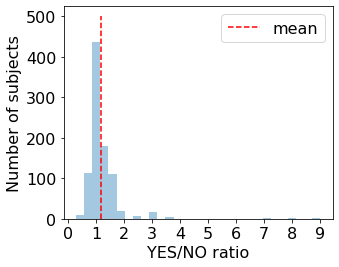

In [273]:
# another way to test for a social bias: look at the #yes/#no ratio --> if >1 this suggests 
# a yes bias
mean_r = data_sure.groupby(["subj_idx","response"]).count().stim
resp_grouped = mean_r.unstack()
print(resp_grouped)
yes_to_no = resp_grouped[1]/resp_grouped[0]

plt.figure(1, figsize=(5,4))
yes_to_no.hist(bins = 30,alpha = 0.4)
plt.grid(None)
#print(np.unique(yes_to_no))
plt.xlabel("YES/NO ratio")
plt.xticks(range(10))
plt.ylabel("Number of subjects")
plt.plot(np.ones((11,1))*np.mean(yes_to_no), np.arange(0,550,50), 'r', ls = 'dashed',label = 'mean')
#plt.ylim(0,450)
plt.tight_layout()
plt.legend()
#print(np.mean(yes_to_no))
stats.wilcoxon(yes_to_no-1)

- Hence, the yes to no ratio is greater than 1 and significant --> i.e., more yes's than no's overall

## 2. SDT estimates for our data

- in addition to counting one or the other responses, we can also use signal detection measures to see how they align with experimenter-assigned labels. For example, a higher number of "social" responses could show in a net(1) response bias towards social, and/or (2) an decrease in d prime (?)

In [274]:
# Function to compute SDT measures like dprime, critia etc. 
from scipy.stats import norm
import math
Z = norm.ppf
 
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

<AxesSubplot:>

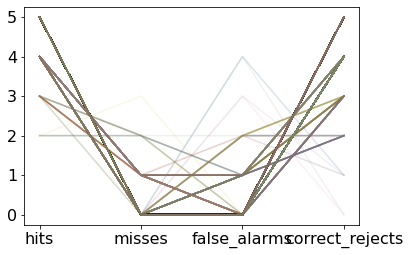

In [275]:
#creating a matrix of hits, FAs, FNs and CRs per subject

matrix = data_sure.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
matrix.head(10)

hits = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits.name='hits'
misses.name='misses'
false_alarms.name='false_alarms'
correct_rejects.name='correct_rejects'

sdt_data = pd.concat([hits, misses, false_alarms, correct_rejects], axis=1)
sdt_data.head()

sdt_data.transpose().plot(legend = None, alpha = 0.1)

In [276]:
#invoke the SDT functions + sample results for subj1
s = 0
SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

{'d': 0.4399303319716861,
 'beta': 0.6268650096300457,
 'c': -1.0615863995587573,
 'Ad': 0.622129231220526}

In [277]:
# extracting SDT measures for each subject and saving in a dataframe
results = {}
for s, subj in enumerate(sdt_data.index.values):
    results[subj] = SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

sdt_measures = pd.DataFrame.from_dict(results, orient="index")
sdt_measures.head()

,d,beta,c,Ad
100206,0.439930,0.626865,-1.061586,0.622129
100307,1.991971,0.735291,-0.154364,0.920514
100408,2.431901,0.852540,-0.065601,0.957249
100610,2.563103,1.000000,-0.000000,0.965037
101410,2.563103,1.000000,-0.000000,0.965037


Text(0, 0.5, 'criterion per subject')

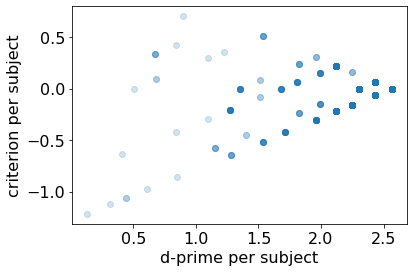

In [278]:
plt.scatter(sdt_measures['d'],sdt_measures['c'],alpha = .2)
stats.spearmanr(sdt_measures['d'],sdt_measures['c'])
plt.xlabel('d-prime per subject')
plt.ylabel('criterion per subject')


In [279]:
sdt_measures.shape

(904, 4)

409060.0 , 1.182885237030678e-152
32681.0 , 7.783930802409245e-19


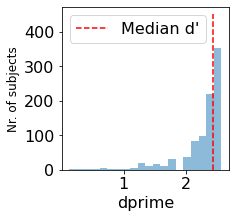

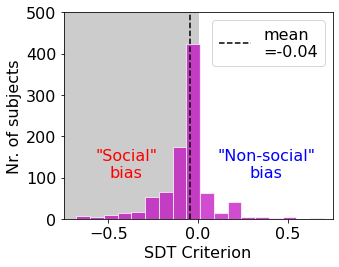

In [280]:
# Plotting the distributions of dprimes and criteria across subjects
# second figure used in the OHBM poster

plt.figure(1,figsize =(3,3))
sdt_measures['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "Median d'")
plt.grid(None)
plt.ylabel('Nr. of subjects', fontsize = 12)
plt.xlabel("dprime")
plt.legend()

std,pd = stats.wilcoxon(sdt_measures['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pd)

plt.figure(2,figsize =(5,4))
#plt.title('Response bias', fontweight = 'bold')
plt.axvspan(-1,0,color=[.8,.8,.8])
#sns.distplot(sdt_measures['c'], bins= 30, label = 'criterion bias across subjects', norm_hist = False)
sdt_measures['c'].hist(bins=25, alpha = .7, color = 'm',edgecolor = 'white')
#plt.vlines(np.nanmean(sdt_measures['c']),0,500,color='r', linewidth = 3,linestyle = 'solid',
#           label = f'mean={np.round(np.nanmean(sdt_measures["c"]),2)},\np(Wilc.)=\n{1.9e-26}')
plt.vlines(np.nanmean(sdt_measures['c']),0,500,color='k', linestyle = 'dashed',
          label = f'mean\n={np.round(np.nanmean(sdt_measures["c"]),2)}')

           #plt.plot(np.zeros((10,1)), np.linspace(0,450,10),\
#         'grey', linestyle = 'dashed',label = f'0(No bias)')

plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("SDT Criterion")
plt.xlim(-.75,.75)
plt.ylim(0,500)
#plt.xticks([-.75,-.5,-.25,0,.25,.5,.75], rotation=30)
#plt.legend(fontsize = 14,bbox_to_anchor=(1.02, 1), loc='upper left')
plt.legend()#bbox_to_anchor = (1.05,1))

plt.text(-.4,100,'"Social"\nbias', ha='center',  color = 'red')
plt.text(.38,100,'"Non-social"\nbias', ha='center', color = 'blue')

#plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
stc, pc = stats.wilcoxon(sdt_measures['c'])
print(stc,',',pc)

plt.tight_layout()

                 subj_idx  movie    rt   run  accuracy  logRT
stim   response                                              
Mental 0              138    138   138   138       138    138
       1             4232   4232  4232  4232      4232   4232
Random 0             3861   3861  3861  3861      3861   3861
       1              199    199   199   199       199    199


Text(0.5, 0, '')

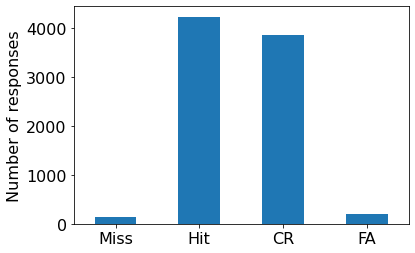

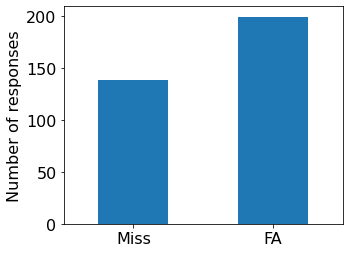

In [98]:
# Distribution of #responses all 4 response types, esp. errors
print(data_sure.groupby(['stim','response']).count())
data_sure.groupby(['stim','response']).count().transpose().loc['accuracy',:].plot.bar()
plt.xticks(range(4),('Miss','Hit','CR','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")

fig,ax = plt.subplots(figsize = (5,4))
data_sure.groupby(['stim','response']).count().transpose().iloc[1,[0,3]].plot.bar()
plt.xticks(range(2),('Miss','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")


## Response modelling

Subject and stimulus being random factors that could've influenced results, it's important to control for them. LMEM lets us control for their effects on the DV using random intercepts and sometimes also on how the regressors affect the DV (using random slopes). The following cells show various LMEMs.

In [281]:
# We use the Python version called pymer4 of the R package lme4.

#from pymer4.test_install import test_install; test_install() # to test pyme4r install
# important: pymer installed in the conda environment py37 (python v3.7x), 
# so if module can't be found here, quit Jupyter and type 'conda activate py37' into terminal

#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm

In [100]:
# model to look for a general bias in responses. The analysis below is a logistic regression,
# so our hypothesis is  if logOR of intercept > 0?
model = Lmer('response ~ (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit()) 

Formula: response~(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -1312.917 	 AIC: 2631.834

Random effects:

                 Name     Var    Std
subj_idx  (Intercept)   0.226  0.476
movie     (Intercept)  13.945  3.734

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     0.379   -1.94    2.698  1.183  1.461      0.144      14.857   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val Sig  
(Intercept)  0.594        0.126         0.937    0.32  0.749      


Interpreting the logistic regression results given above:
log(p(r=1)/p(r=0)) = .379 So p(r=1)/p(r=0) = exp(.379) > 1, so p(r=1) is more likely, BUT p-value = 0.749 so results are not significant.

In [21]:
# Next model: response = f(stimulus Type)
model = Lmer('response ~ stim + (1|subj_idx)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())

Formula: response~stim+(1|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0}

Log-likelihood: -1403.805 	 AIC: 2813.610

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.588  0.767

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -3.213  -3.445   -2.980  0.118    0.040      0.032       0.051   
stim1           6.887   6.474    7.299  0.211  979.002    648.015    1479.047   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.039        0.031         0.048 -27.133    0.0  ***  
stim1        0.999        0.998         0.999  32.711    0.0  ***  


Results indicate that logOR for stim >0, i.e., p(r=1)/p(r=0) increases from the intercept for Mental compared to random

In [58]:
#Does adding movie improve the model?
model = Lmer('response ~ stim + (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())

Formula: response~stim+(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -1298.486 	 AIC: 2604.971

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.251  0.501
movie     (Intercept)  0.739  0.860

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        OR  OR_2.5_ci  \
(Intercept)    -3.247  -4.026   -2.468  0.397     0.039      0.018   
stim1           7.229   6.104    8.355  0.574  1379.435    447.673   

             OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)       0.085  0.037        0.018         0.078  -8.169    0.0  ***  
stim1          4250.513  0.999        0.998         1.000  12.591    0.0  ***  


Results are still significant, and AIC reduces so model does improve

Text(0, 0.5, 'mean response per cat.')

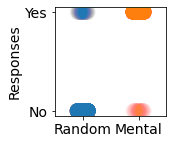

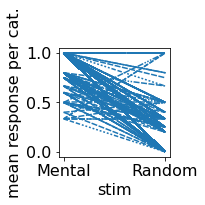

In [26]:
# Plotting response vs. stimulus. 
fig,ax = plt.subplots(figsize = (2,2))

sns.stripplot(data=data_sure, x="stim",y="response", order = ["Random","Mental"],ax=ax, alpha = 0.005, size=16)
ax.set_yticks(range(2))
ax.set_yticklabels(["No","Yes"],size=14)
ax.set_xticklabels(["Random","Mental"],size=14)
ax.set_ylabel('Responses',size = 14)
ax.set_xlabel('')

#A different way to look at this - subjectwise mean responses per category 
#(for mental, Y-values closer to 1 is more accurate, and for random, values near 0)

fig,ax = plt.subplots(figsize = (2,2))
summary = data_sure.groupby(['subj_idx','stim']).mean()
sns.lineplot(data=summary, x="stim", y="response", style="subj_idx",legend = False)
ax.set_ylabel("mean response per cat.")

In [76]:
# adding random slopes for subject
model = Lmer('response ~ stim + (stim|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())

Formula: response~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -1255.479 	 AIC: 2522.957

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  2.164  1.471
subj_idx   stimMental  6.595  2.568
movie     (Intercept)  0.594  0.770

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.958

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        OR  OR_2.5_ci  \
(Intercept)    -4.014  -4.805   -3.224  0.403     0.018      0.008   
stim1           8.565   7.412    9.718  0.588  5245.025   1655.070   

             OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)       0.040  0.018        0.008         0.038  -9.951    0.0  ***  
stim1         16621.829  1.000        0.999         1.000  14.554    0.0  ***  


model improves a little on adding RS

## Reaction time LMEMs

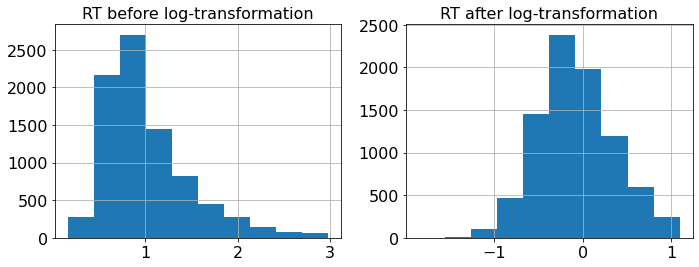

In [282]:
#log-transforming RT makes the distribution closer to a Gaussian
data_sure = data_sure.assign(logRT = np.log(data_sure['rt'])) # add a column for logRT
data_sure.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure['logRT'].hist()
plt.tight_layout()

- Most of the analyses will be done on the sure responses.
- RT is skewed and hence we take its log-transform (still not fully normal)

<font color=red> TODO sometime: Look for the best family of distribution for RT (better than log) potentially using KL divergence, shift to glmer function and perhaps R </font>

,subj_idx,stim,movie,rt,response,run,accuracy,socialness
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,0.972490
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,0.993122
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,0.023578
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,1.000000
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,0.044733
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,0.009655
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,0.006925
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,0.925180
9,668361,Random,Random mechanical.AVI,0.816,0,0,1.0,0.126230


Text(0.5, 0, 'Response time(sec)')

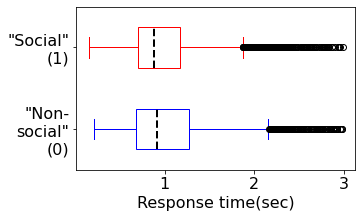

In [283]:
#rt_per_resptype_mean = data_sure.groupby(['response']).mean().rt
#rt_per_resptype_sem = data_sure.groupby(['response']).sem().rt


#plt.figure(1, figsize=(5,2))
fig, ax = plt.subplots(figsize=(5,3))
#plt.figure(1,figsize=(3,4))
#plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
#ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
bp1 = box_plot(data_sure.loc[data_sure['response']==1,'rt'], 'red', 'tan',1,False)
bp2 = box_plot(data_sure.loc[data_sure['response']==0,'rt'], 'blue', 'cyan',0,False)

rts_per_subj = data_sure.groupby(['subj_idx', 'response']).mean().logRT.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj['diff'] = rts_per_subj[1]-rts_per_subj[0]


plt.ylabel('')
plt.yticks((range(2)),('"Non-\nsocial"\n(0)','"Social"\n(1)'))
plt.xlabel('Response time(sec)')
#plt.title('Reaction time', fontsize =20, fontweight = 'bold')
#plt.ylim(0.9,1.1)




In [284]:
rts_per_subj.shape

(904, 3)

Text(0.5, 0, 'RTSoc-RTNonSoc per sub.')

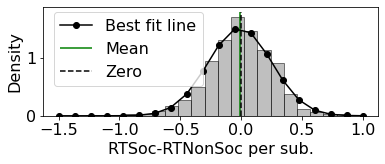

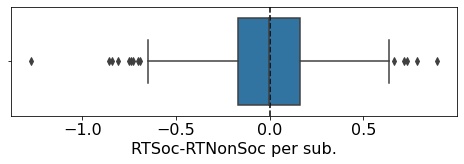

In [236]:
plt.figure(2, figsize=(6,2))
data = rts_per_subj['diff'].values
data  = data[~np.isnan(data)]
_, bins, _ = plt.hist(data, 20, density=1, alpha=0.5,color = 'grey', align = 'mid',edgecolor = 'k')
mu, sigma = scipy.stats.norm.fit(data)
xpts = np.linspace(-1.5,1,20)
best_fit_line = scipy.stats.norm.pdf(xpts, mu, sigma)
plt.plot(xpts, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [0.5,0.2])

plt.figure(3, figsize=(8,2))
sns.boxplot(x=data)
ymin,ymax = plt.ylim()
#plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
#plt.ylabel('Density')
#plt.legend(bbox_to_anchor = [1,1])

#sns.boxplot(x = "response",y="rt", data = rts_per_subj)

#plt.bar(range(2),rt_per_resptype_mean,color = 'grey',alpha = .4)
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
#plt.errorbar(range(2),rt_per_resptype_mean,rt_per_resptype_sem, color = 'black', ls = 'none', marker = 'o', markersize = 8)
#plt.tight_layout()
#plt.xlabel('')
#plt.xticks((range(2)),('Non-\nsocial\n(0)','Social\n(1)'), fontsize = 20, rotation =30)
#plt.ylabel('Time (secs)',fontsize = 24)
#plt.title('Reaction time', fontsize =20, fontweight = 'bold')
#plt.ylim(0.9,1.1)

response        0       1
subj_idx                 
100206    0.68300  1.1220
100307    0.70150  0.6224
100408    1.32925  1.2596
100610    0.87040  1.1614
101410    1.19880  0.7750
...           ...     ...
991267    0.98275  0.8480
992673    1.31420  1.2486
992774    0.50275  0.5860
993675    1.03840  1.4302
996782    0.82120  0.9080

[904 rows x 2 columns]


Ttest_relResult(statistic=4.000196929971676, pvalue=6.84811954804191e-05)

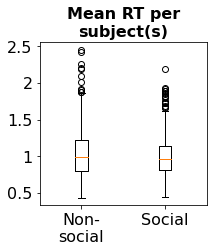

In [110]:
rt_per_subj = data_sure.groupby(['subj_idx', 'response']).mean().rt # Mean count per subject for Mental and Random
cols = rt_per_subj.unstack(level = -1)
print(cols)
plt.figure(1, figsize=(3,3))
#plt.bar(range(2),cols.mean(),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
#plt.errorbar(range(2),cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
#plt.tight_layout()
plt.boxplot([cols.loc[~np.isnan(cols.iloc[:,0]),0], cols.loc[~np.isnan(cols.iloc[:,1]),1]])

plt.xticks((1+np.arange(2)),('Non-\nsocial','Social'), fontsize = 16)
plt.yticks([.5,1,1.5,2,2.5], [str(i) for i in [.5,1,1.5,2,2.5]],fontsize = 16)

plt.title('Mean RT per\nsubject(s)', fontsize =16, fontweight = 'bold')
stats.ttest_rel(cols[0],cols[1],nan_policy='omit')



In [238]:
print(np.nanmean(data_sure.loc[data_sure['response']==1,'rt']),np.nanmean(data_sure.loc[data_sure['response']==0,'rt']))
stats.ttest_ind(data_sure.loc[data_sure['response']==1,'rt'],data_sure.loc[data_sure['response']==0,'rt'],nan_policy='omit')


0.9901060523446019 1.0144508484493857


Ttest_indResult(statistic=-2.225069519660046, pvalue=0.026107941896374907)

Model failed to converge with max|grad| = 0.00268499 (tol = 0.002, component 1) 

Formula: logRT~stim+(stim|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 4620	 Groups: {'subj_idx': 462.0, 'movie': 10.0}

Log-likelihood: -1782.142 	 AIC: 3564.283

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.048  0.220
subj_idx   stimMental  0.013  0.115
movie     (Intercept)  0.034  0.185
Residual               0.105  0.324

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.554

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.113  -0.276    0.051  0.083  8.244  -1.348  0.214    
stim1           0.005  -0.225    0.235  0.117  8.032   0.041  0.968    
stim
Mental    0.973113
Random    0.985567
Name: rt, dtype: float64


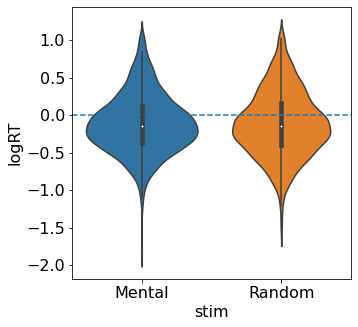

In [247]:
# since RT is quantitative, these analyses are linear regressions
model = Lmer('logRT ~  stim +(stim|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term

# plotting the results
fig,ax = plt.subplots(figsize = (5,5))
sns.violinplot(data=data_sure, x="stim",y="logRT", ax=ax)
ax.axhline(0, linestyle='--')
print(data_sure.groupby("stim").mean().rt)

stimtype has no effect on RTs in a model that accounts for subj and movies

Is response a better predictor than stimulus of the RT?

Formula: logRT~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -3428.105 	 AIC: 6856.211

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.059  0.243
subj_idx     response  0.022  0.150
movie     (Intercept)  0.031  0.176
Residual               0.107  0.327

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.602

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.055  -0.167    0.058  0.057     9.957  -0.956  0.362    
response       -0.036  -0.076    0.003  0.020  4753.711  -1.813  0.070   .


NormaltestResult(statistic=290.3770083009352, pvalue=8.819293820861547e-64)

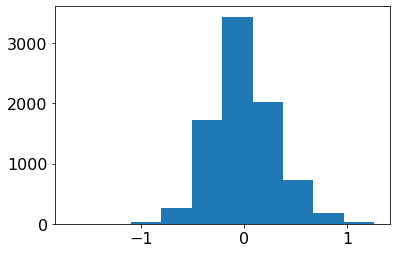

In [285]:
model = Lmer('logRT ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+(response|subj_idx)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0}

Log-likelihood: -4363.387 	 AIC: 8726.775

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.050  0.224
subj_idx     response  0.007  0.086
Residual               0.143  0.378

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.701

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    -0.070  -0.089   -0.051  0.010  873.407  -7.314  0.000  ***
response       -0.017  -0.034    0.000  0.009  867.795  -1.916  0.056    .


NormaltestResult(statistic=157.98464285049153, pvalue=4.94391154961759e-35)

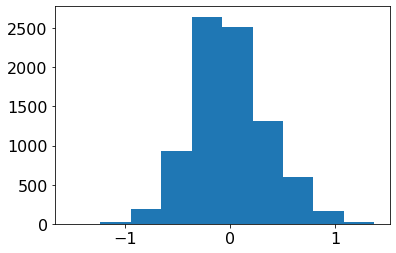

In [286]:
model = Lmer('logRT ~  response +(response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+movie+(response|subj_idx)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0}

Log-likelihood: -3429.787 	 AIC: 6859.573

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.059  0.243
subj_idx     response  0.022  0.150
Residual               0.107  0.327

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.602

Fixed effects:

                            Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                    0.120   0.092    0.147  0.014  3248.426   
response                      -0.037  -0.077    0.003  0.020  6686.734   
movieCOAXING-B.AVI             0.081   0.033    0.130  0.025  7467.250   
movieDRIFTING-A.AVI           -0.199  -0.230   -0.168  0.016  6709.762   
movieFishing.AVI              -0.005  -0.052    0.042  0.024  7588.158   
movieRandom mechanical.AVI    -0.078  -0.112   -0.044  0.017  6993.272   
movieSEDUCING-B.AVI           -

NormaltestResult(statistic=290.1200301207868, pvalue=1.0028498513591465e-63)

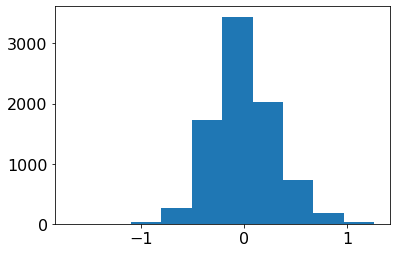

In [116]:
model = Lmer('logRT ~  response + movie + (response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+(response|subj_idx)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0}

Log-likelihood: -4363.387 	 AIC: 8726.775

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.050  0.224
subj_idx     response  0.007  0.086
Residual               0.143  0.378

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.701

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    -0.070  -0.089   -0.051  0.010  873.407  -7.314  0.000  ***
response       -0.017  -0.034    0.000  0.009  867.795  -1.916  0.056    .


NormaltestResult(statistic=157.98464285049153, pvalue=4.94391154961759e-35)

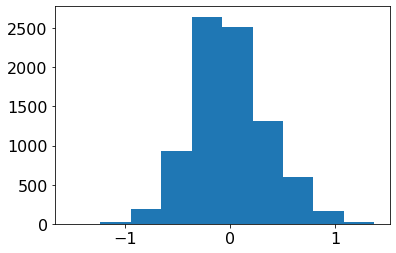

In [119]:
model = Lmer('logRT ~  response +(response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -3428.105 	 AIC: 6856.211

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.059  0.243
subj_idx     response  0.022  0.150
movie     (Intercept)  0.031  0.176
Residual               0.107  0.327

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.602

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.055  -0.167    0.058  0.057     9.957  -0.956  0.362    
response       -0.036  -0.076    0.003  0.020  4753.711  -1.813  0.070   .


NormaltestResult(statistic=290.3770083009352, pvalue=8.819293820861547e-64)

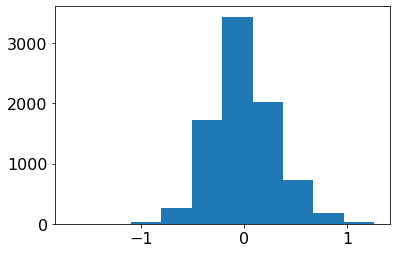

In [118]:
model = Lmer('logRT ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough

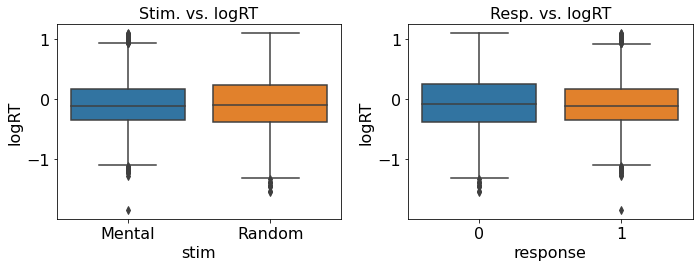

In [120]:
plt.figure(1,figsize = (10,4))
plt.subplot(121)
sns.boxplot(data=data_sure, x="stim", y="logRT")
plt.title('Stim. vs. logRT')

plt.subplot(122)
sns.boxplot(data=data_sure, x="response", y="logRT")
plt.title('Resp. vs. logRT')

plt.tight_layout()

In [164]:
# does the influence of stim and response depend on each other?
model = Lmer('logRT ~  stim*response + (1|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]}))

Formula: logRT~stim*response+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -3454.088 	 AIC: 6908.176

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.041  0.202
movie     (Intercept)  0.034  0.184
Residual               0.112  0.335

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       -0.073  -0.235    0.089  0.083     8.116  -0.883  0.403     
stim1              0.182  -0.054    0.419  0.121     9.120   1.514  0.164     
response           0.078   0.026    0.129  0.026  8041.464   2.948  0.003   **
stim1:response    -0.273  -0.354   -0.192  0.041  8090.170  -6.607  0.000  ***


looks like there's a strong interaction

MultiIndex([('Mental', 0.0),
            ('Mental', 1.0),
            ('Random', 0.0),
            ('Random', 1.0)],
           names=['stim', 'accuracy'])
stim    accuracy
Mental  0.0         1.343870
        1.0         0.990035
Random  0.0         1.152970
        1.0         1.018044
Name: rt, dtype: float64


Text(0.5, 0, '')

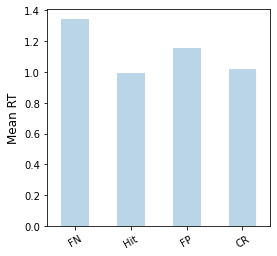

In [166]:
# Distribution of all 4 response types, esp. errors

rt_per_respType = data_sure.groupby(['stim','accuracy']).mean().rt
print(rt_per_respType.index)
print(rt_per_respType)
fig,ax = plt.subplots(figsize = (10,4))
#acc_per_movie.plot.bar()
rt_per_respType.plot.bar(figsize = (4,4), alpha = 0.3)
ax.set_ylabel('Mean RT', fontsize = 12)
ax.set_xticks(range(4))
lbl = ['FN','Hit','FP','CR'] # first four letters of each movie name
ax.set_xticklabels(lbl, rotation = 30)

ax.set_xlabel('')

Formula: logRT~accuracy+(accuracy|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 8430	 Groups: {'subj_idx': 904.0, 'movie': 10.0}

Log-likelihood: -3438.260 	 AIC: 6876.520

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.066  0.257
subj_idx     accuracy  0.057  0.239
movie     (Intercept)  0.030  0.174
Residual               0.110  0.332

                  IV1       IV2   Corr
subj_idx  (Intercept)  accuracy -0.657

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.058  -0.061    0.176  0.060   12.908   0.955  0.357     
accuracy       -0.137  -0.186   -0.088  0.025  215.413  -5.483  0.000  ***


(array([2.000e+00, 5.000e+00, 2.300e+01, 3.120e+02, 1.915e+03, 3.468e+03,
        1.843e+03, 6.780e+02, 1.670e+02, 1.700e+01]),
 array([-1.72793118, -1.42103992, -1.11414866, -0.8072574 , -0.50036615,
        -0.19347489,  0.11341637,  0.42030763,  0.72719889,  1.03409015,
         1.34098141]),
 <BarContainer object of 10 artists>)

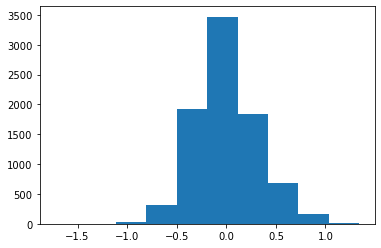

In [171]:
# logRT =f(accuracy)
model = Lmer('logRT ~  accuracy +(accuracy|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

not very different in terms of AIC from the model with response regressor. P-value is sig  and estimate negative
meaning that correct responses have shorter RTs

## 3. Uncertainty plots

In [64]:
# going back to the whole data with sure and unsure trials
dat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0
9,668361,Random,Random mechanical.AVI,0.816,0,0,1.0


In [288]:
certainty = np.ones(len(dat['response']))
certainty = [1 if i != 9 else 0 for i in dat['response'].values]
dat['certainty'] = certainty
uncertainty = [0 if i != 9 else 1 for i in dat['response'].values]
dat['uncertainty'] = uncertainty

#dat = dat.assign(certainty)
dat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,certainty,uncertainty
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,1,0
9,668361,Random,Random mechanical.AVI,0.816,0,0,1.0,1,0


In [66]:
stim_mean = data_sure.groupby(['movie']).mean().response # this shouldn't include unsure data
stim_mean.shape

(10,)

In [68]:
n = len(vid_names["run1"])+len(vid_names["run2"])
socialness = np.zeros(len(dat['response']))
for m in range(n):
    rows = np.where(dat["movie"] == stim_mean.index[m])[0]
    socialness[rows] = stim_mean[m]
dat['socialness'] = socialness # add new column
dat.head()

,subj_idx,stim,movie,rt,response,run,accuracy,certainty,uncertainty,socialness
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,1,0,0.964824
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,1,0,0.981057
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,1,0,0.043433
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,1,0,0.983317
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,1,0,0.055879


Formula: certainty~socialness+(socialness|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.136 	 AIC: 4250.272

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.976  0.988
subj_idx   socialness  0.766  0.875
movie     (Intercept)  0.577  0.760

                  IV1         IV2  Corr
subj_idx  (Intercept)  socialness -0.54

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     2.646   1.922    3.370  0.370  14.098      6.832      29.092   
socialness      1.467   0.380    2.554  0.554   4.336      1.462      12.854   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.934        0.872         0.967   7.159  0.000  ***  
socialness   0.813        0.594         0.928   2.645  0.008   **  


(array([4.000e+01, 1.620e+02, 3.270e+02, 9.500e+01, 1.600e+01, 1.000e+00,
        0.000e+00, 8.035e+03, 1.233e+03, 3.900e+01]),
 array([-2.93294977, -2.50620858, -2.0794674 , -1.65272621, -1.22598502,
        -0.79924384, -0.37250265,  0.05423853,  0.48097972,  0.9077209 ,
         1.33446209]),
 <BarContainer object of 10 artists>)

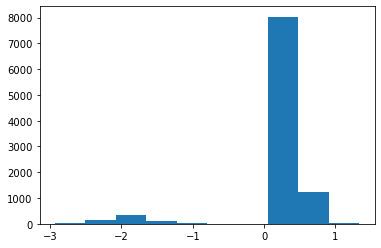

In [141]:
# certainty of responses as a function of perceived socialness
model = Lmer('certainty ~  socialness +(socialness|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: certainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.181 	 AIC: 4250.363

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.833  0.912
subj_idx   stimRandom  0.626  0.791
movie     (Intercept)  0.560  0.748

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimRandom -0.382

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     4.083   3.371    4.796  0.364  59.336     29.096     121.003   
stimRandom     -1.373  -2.350   -0.396  0.499   0.253      0.095       0.673   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.983        0.967         0.992  11.231  0.000  ***  
stimRandom   0.202        0.087         0.402  -2.753  0.006   **  


(array([3.800e+01, 1.340e+02, 2.430e+02, 2.100e+02, 1.500e+01, 1.000e+00,
        0.000e+00, 8.030e+03, 1.238e+03, 3.900e+01]),
 array([-2.93187413, -2.50715138, -2.08242863, -1.65770587, -1.23298312,
        -0.80826037, -0.38353761,  0.04118514,  0.46590789,  0.89063065,
         1.3153534 ]),
 <BarContainer object of 10 artists>)

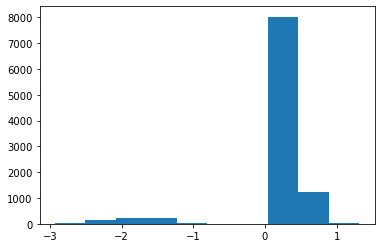

In [144]:
# certainty as a function of stimtype
model = Lmer('certainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.179 	 AIC: 4250.358

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.905  0.952
subj_idx   stimMental  0.627  0.792
movie     (Intercept)  0.560  0.748

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.462

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.710  -3.383   -2.037  0.343  0.067      0.034       0.130   
stim1          -1.375  -2.352   -0.398  0.499  0.253      0.095       0.672   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.062        0.033         0.115  -7.891  0.000  ***  
stim1        0.202        0.087         0.402  -2.759  0.006   **  


(array([3.900e+01, 1.239e+03, 8.029e+03, 0.000e+00, 1.000e+00, 1.500e+01,
        2.100e+02, 2.420e+02, 1.350e+02, 3.800e+01]),
 array([-1.31489627, -0.89027337, -0.46565046, -0.04102756,  0.38359535,
         0.80821826,  1.23284116,  1.65746407,  2.08208697,  2.50670988,
         2.93133278]),
 <BarContainer object of 10 artists>)

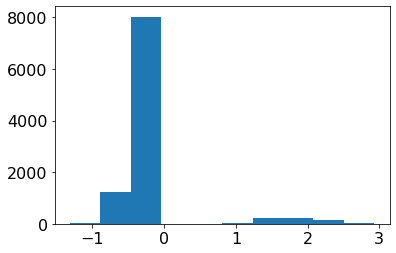

In [289]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

In both the analyses above, the regressors where significant indicating that response certainty can be predicted from binary stimType or continuous (based on general consensus) socialness

In [159]:
print('Mental')
for q in [.25,.5,.75]:
    print(np.quantile(summary['Mental'],q))
print('Random')
for q in [.25,.5,.75]:
    print(np.quantile(summary['Random'],q))

Mental
0.0
0.0
0.0
Random
0.0
0.0
20.0


stim      Random  Mental
subj_idx                
100206       0.0     0.0
100307       0.0    20.0
100408      20.0     0.0
100610       0.0     0.0
101006      25.0     0.0


Text(0, 0.5, 'Unsure responses\n(in percent)')

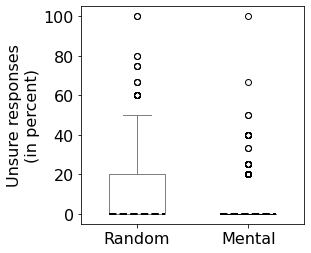

In [290]:
#plt.figure(1,figsize = (3,3))
fig,ax=plt.subplots(figsize = (4,4))
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
cols = summary.columns.tolist()
cols = cols[-1:] + cols[:-1]
summary = summary[cols]
summary = summary.loc[(~np.isnan(summary['Random'])&(~np.isnan(summary['Mental']))),:]
print(summary.head())
mn = summary.mean()
sem = summary.sem()

bp1 = box_plot(summary['Random'], 'grey', 'tan',0,True)
bp2 = box_plot(summary['Mental'], 'black', 'cyan',1,True)

'''for i in range(rts_per_subj.shape[0]):
    plt.plot(range(2),rts_per_subj.iloc[i,:2],color='k',alpha=.1,label = 'subject')
    if i ==0:
        plt.legend(bbox_to_anchor=(1.05,1))'''

        
#Figure 1c in the submitted OHBM abstract
#sns.barplot(data=summary,alpha=.5,edgecolor='k')
plt.xticks((0,1),('Random','Mental'))
plt.xlabel('')
plt.ylabel("Unsure responses\n(in percent)")
#plt.title('Unsure responses',fontweight='bold')

In [293]:
dat.shape

(9948, 9)

In [291]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0}

Log-likelihood: -2249.163 	 AIC: 4508.326

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.889  0.943
subj_idx   stimMental  2.737  1.654

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.349

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.571  -2.740   -2.402  0.086  0.076      0.065       0.091   
stim1          -1.796  -2.292   -1.300  0.253  0.166      0.101       0.273   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.071        0.061         0.083 -29.745    0.0  ***  
stim1        0.142        0.092         0.214  -7.093    0.0  ***  


stim
Mental    0.966444
Random    0.902034
Name: certainty, dtype: float64


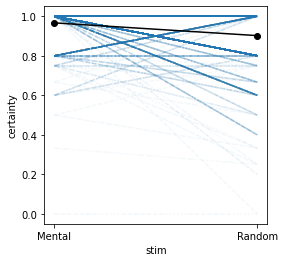

In [148]:
# Alternate version of the last plot showing individual values
fig,ax = plt.subplots(figsize = (4,4))
summary = dat.groupby(['subj_idx','stim']).mean()
print(summary.reset_index().groupby('stim').mean().certainty)
sns.lineplot(data=summary, x="stim", y="certainty", style="subj_idx",legend = False, alpha = 0.05)
plt.plot(summary.reset_index().groupby('stim').mean().certainty, color = 'black', marker = 'o')
#summary.plot(x="stim",y="response", stacked = True)
#ax.set_xticks((0,1))
#ax.set_xticklabels(('No','Yes'), fontsize = 'x-large')
#ax.set_ylabel("RT", fontsize = 'x-large')

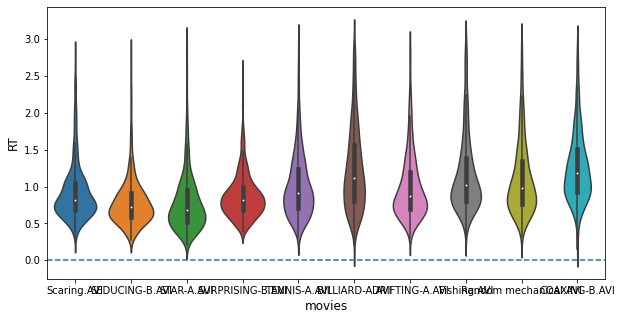

In [161]:
#RT across mean socialness values (or movies)
fig,ax = plt.subplots(figsize = (10,5))
sns.violinplot(x="movie",y="rt",data=data_sure, ax=ax)
ax.set_xticks(range(10))
ax.set_xlabel('movies',fontsize = 12)
ax.set_ylabel('RT',fontsize = 12)
ax.axhline(0, linestyle='--')

# Extra code

<AxesSubplot:xlabel='diff'>

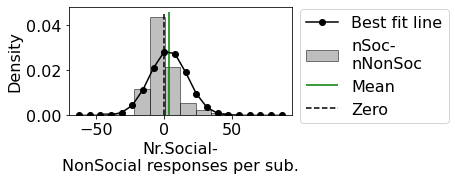

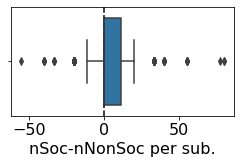

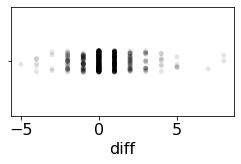

In [249]:
fig = plt.figure(1, figsize=(4,2))

data = counts_per_subj['Soc-NonSoc_pc'].values
_, bins, _ = plt.hist(data, 12, density=1, alpha=0.5,color = 'grey',label = 'nSoc-\nnNonSoc', align = 'mid',edgecolor = 'k')
#plt.hist(data,bins=bins)

mu, sigma = scipy.stats.norm.fit(data)
xmin,xmax = plt.xlim()
x =  np.linspace(xmin,xmax,20)
best_fit_line = scipy.stats.norm.pdf(x, mu, sigma)
plt.plot(x, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('Nr.Social-\nNonSocial responses per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [1,1.05])

plt.figure(2, figsize=(4,2))

sns.boxplot(x=data)
#sns.boxplot(x="diff", data = cols)
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('nSoc-nNonSoc per sub.')

plt.figure(3, figsize=(4,2))
sns.stripplot(x = "diff", data = counts_per_subj, color = 'k',  alpha = .1)

